### Importing libraries

In [2]:
import pandas as pd 
import numpy as np
import math 
import matplotlib.pyplot as plt 
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import tensorflow as tf
import dice_ml
from dice_ml.utils import helpers

### Data Modelling

Ingesting data

In [ ]:
df = pd.read_csv('data/df_original_model_clean.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

X = df.drop(columns=['Turnover', 'Date', 'Game', 'Location'])
y = df['Turnover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1994)

print(f"X_train dims: {X_train.shape} \ny_train dims: {y_train.shape} \nX_test dims: {X_test.shape} \ny_test dims: {y_test.shape}")

XGBoostRegressor for later use with counterfactuals

In [11]:
reg = XGBRegressor().fit(X_train, y_train)
preds = reg.predict(X_train)
print(f"MAE on training data is: {mean_absolute_error(y_train, preds):.2f}")

MAE on training data is: 3768.71


Bin the turnover and run different scores for each

In [8]:
def calc_bin_mae(bin_test):
    test_1 = bin_test[bin_test['Turnover']<=5000]
    y_test_1 = test_1['Turnover']
    X_test_1 = test_1.drop(columns=['Turnover'])
    preds = reg.predict(X_test_1)
    print(f"MAE on test data 1 [0,5000] Turnover is: {mean_absolute_error(y_test_1, preds):.2f}")

    test_2 = bin_test[(bin_test['Turnover']>5000) & (bin_test['Turnover']<=10000)]
    y_test_2 = test_2['Turnover']
    X_test_2 = test_2.drop(columns=['Turnover'])
    preds = reg.predict(X_test_2)
    print(f"MAE on test data 2 [5000,10000] Turnover is: {mean_absolute_error(y_test_2, preds):.2f}")

    test_3 = bin_test[(bin_test['Turnover']>10000) & (bin_test['Turnover']<=15000)]
    y_test_3 = test_3['Turnover']
    X_test_3 = test_3.drop(columns=['Turnover'])
    preds = reg.predict(X_test_3)
    print(f"MAE on test data 3 [10000,15000] Turnover is: {mean_absolute_error(y_test_3, preds):.2f}")

    test_4 = bin_test[(bin_test['Turnover']>15000) & (bin_test['Turnover']<=25000)]
    y_test_4 = test_4['Turnover']
    X_test_4 = test_4.drop(columns=['Turnover'])
    preds = reg.predict(X_test_4)
    print(f"MAE on test data 4 [15000,25000] Turnover is: {mean_absolute_error(y_test_4, preds):.2f}")

    test_5 = bin_test[(bin_test['Turnover']>25000) & (bin_test['Turnover']<=35000)]
    y_test_5 = test_5['Turnover']
    X_test_5 = test_5.drop(columns=['Turnover'])
    preds = reg.predict(X_test_5)
    print(f"MAE on test data 5 [25000,35000] Turnover is: {mean_absolute_error(y_test_5, preds):.2f}")

    test_6 = bin_test[bin_test['Turnover']>35000]
    y_test_6 = test_6['Turnover']
    X_test_6 = test_6.drop(columns=['Turnover'])
    preds = reg.predict(X_test_6)
    print(f"MAE on test data 6 [35000,+] Turnover is: {mean_absolute_error(y_test_6, preds):.2f}")

In [9]:
bin_test = pd.concat([X_test, y_test], axis=1)
calc_bin_mae(bin_test)

MAE on test data 1 [0,5000] Turnover is: 1771.93
MAE on test data 2 [5000,10000] Turnover is: 3591.10
MAE on test data 3 [10000,15000] Turnover is: 4734.07
MAE on test data 4 [15000,25000] Turnover is: 6370.91
MAE on test data 5 [25000,35000] Turnover is: 8238.35
MAE on test data 6 [35000,+] Turnover is: 17981.06


### Dice - counterfactual explanations

https://github.com/interpretml/DiCE

In [6]:
df = pd.read_csv('data/df_original_model_clean.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

In [50]:
df.loc[4807] # underestimated

Date                  2022-05-21 00:00:00
Location_Weighting                 0.0025
Weighted_Days                      0.1649
Location                               80
Column                                  7
                             ...         
Theme_Wild                              0
Theme_Wild West                         0
Theme_Win                               0
Theme_Wins                              0
Theme_Wolf                              0
Name: 4807, Length: 176, dtype: object

In [7]:
X = df.drop(columns=['Date', 'Game', 'Location'])
y = df['Turnover']

In [53]:
continuous_features = X.drop(['Turnover'], axis=1).columns.tolist()

In [54]:
d_position = dice_ml.Data(dataframe=X, continuous_features=continuous_features, outcome_name="Turnover")
# We provide the type of model as a parameter (model_type)
m_position = dice_ml.Model(model=reg, backend="sklearn", model_type='regressor')

exp_genetic_position = dice_ml.Dice(d_position, m_position, method="genetic")

In [ ]:
query_instances = X[0:10].drop(['Turnover'], axis=1)

In [ ]:
genetic_position = exp_genetic_position.generate_counterfactuals(query_instances,
                                                               total_CFs=1,
                                                               desired_range=[15000.0, 25000.0], verbose=0, features_to_vary=['Column', 'Row'])

In [98]:
genetic_position.visualize_as_dataframe(show_only_changes=False)

Query instance (original outcome : 11243)


,Location_Weighting,Weighted_Days,Column,Row,Active,Weighting_Tile,Branded_Game,Lines,Reels,Free_Game,...,Theme_Wanted,Theme_Warrior,Theme_Ways,Theme_Weather,Theme_Wild,Theme_Wild West,Theme_Win,Theme_Wins,Theme_Wolf,Turnover
0,0.002,0.1445,1.0,6.0,1.0,1.0,0.0,-0.398407,-0.3769,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11243.394531



Diverse Counterfactual set (new outcome: [15000.0, 25000.0])


,Location_Weighting,Weighted_Days,Column,Row,Active,Weighting_Tile,Branded_Game,Lines,Reels,Free_Game,...,Theme_Wanted,Theme_Warrior,Theme_Ways,Theme_Weather,Theme_Wild,Theme_Wild West,Theme_Win,Theme_Wins,Theme_Wolf,Turnover
0,0.002,0.1445,1.0,2.0,1.0,1.0,0.0,-0.398407,-0.3769,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23846.90625


Query instance (original outcome : 13565)


,Location_Weighting,Weighted_Days,Column,Row,Active,Weighting_Tile,Branded_Game,Lines,Reels,Free_Game,...,Theme_Wanted,Theme_Warrior,Theme_Ways,Theme_Weather,Theme_Wild,Theme_Wild West,Theme_Win,Theme_Wins,Theme_Wolf,Turnover
0,0.0021,0.152,1.0,6.0,1.0,1.0,0.0,-0.398407,-0.3769,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13565.198242



Diverse Counterfactual set (new outcome: [15000.0, 25000.0])


,Location_Weighting,Weighted_Days,Column,Row,Active,Weighting_Tile,Branded_Game,Lines,Reels,Free_Game,...,Theme_Wanted,Theme_Warrior,Theme_Ways,Theme_Weather,Theme_Wild,Theme_Wild West,Theme_Win,Theme_Wins,Theme_Wolf,Turnover
0,0.0021,0.152,10.0,2.0,1.0,1.0,0.0,-0.398407,-0.3769,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24328.65625


### Shap Explainable AI

https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [1]:
import shap

/Users/andreas/opt/anaconda3/envs/model_explainability/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


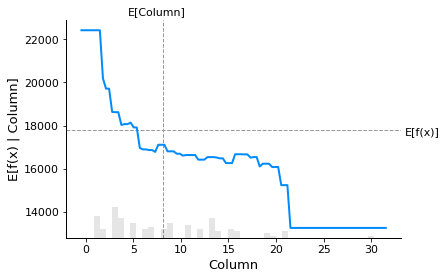

In [9]:
X100 = shap.utils.sample(X, 100)

shap.partial_dependence_plot(
    "Column", reg.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

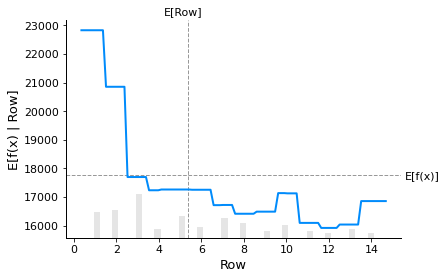

In [10]:
X100 = shap.utils.sample(X, 100)

shap.partial_dependence_plot(
    "Row", reg.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

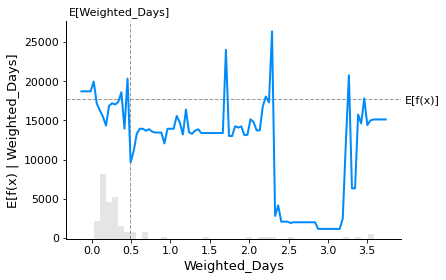

In [11]:
X100 = shap.utils.sample(X, 100)

shap.partial_dependence_plot(
    "Weighted_Days", reg.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

In [14]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(reg.predict, X100)
shap_values = explainer(X)

Permutation explainer: 6683it [21:15,  5.19it/s]                          


In [13]:
sample_ind = 20

The additive nature of Shapley values

One of the fundemental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present. For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained. The easiest way to see this is through a waterfall plot that starts at our background prior expectation for a home price , and then adds features one at a time until we reach the current model output :

#### Forensic analysis of two records with high MAE and fault percentage error, let's see why the estimator underestimated and overestimated those two records

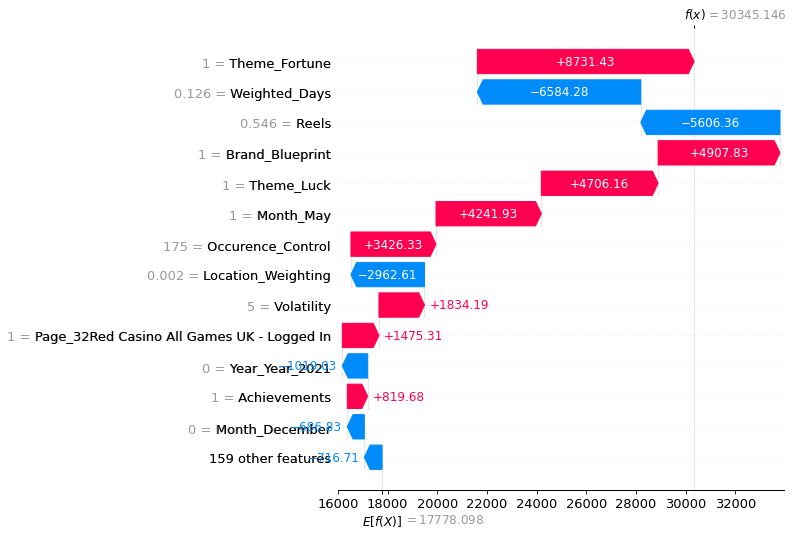

In [18]:
shap.plots.waterfall(shap_values[4654], max_display=14) # overestimated

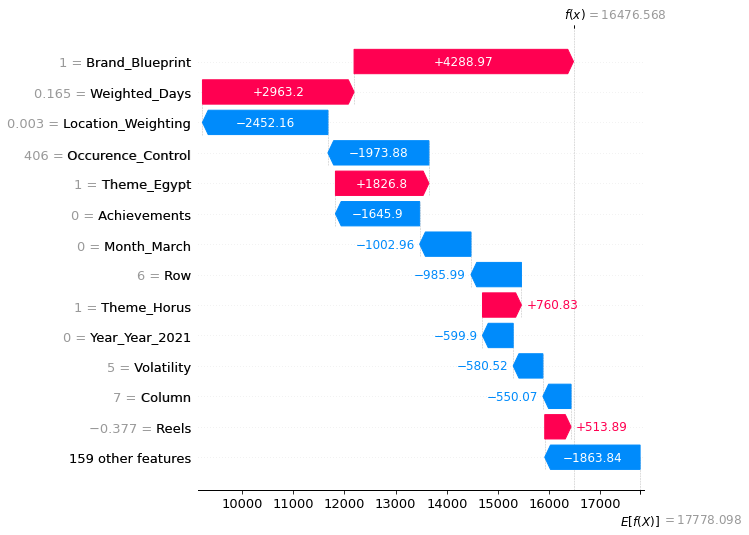

In [16]:
shap.plots.waterfall(shap_values[4807], max_display=14) # underestimated

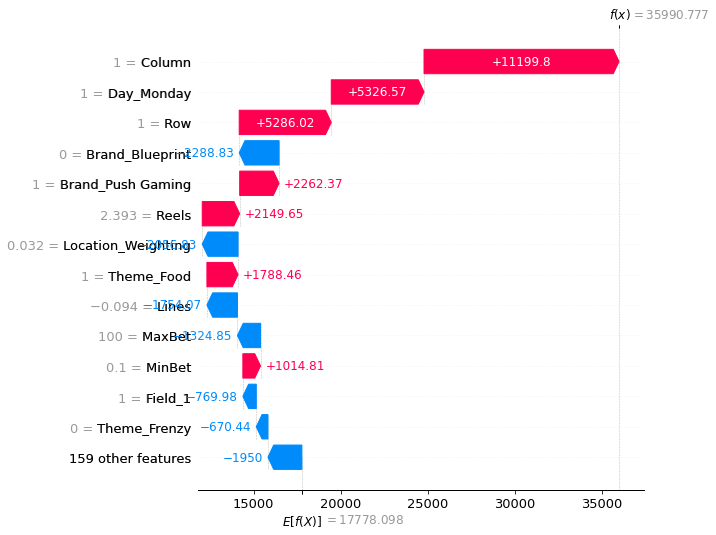

In [79]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[2238], max_display=14)

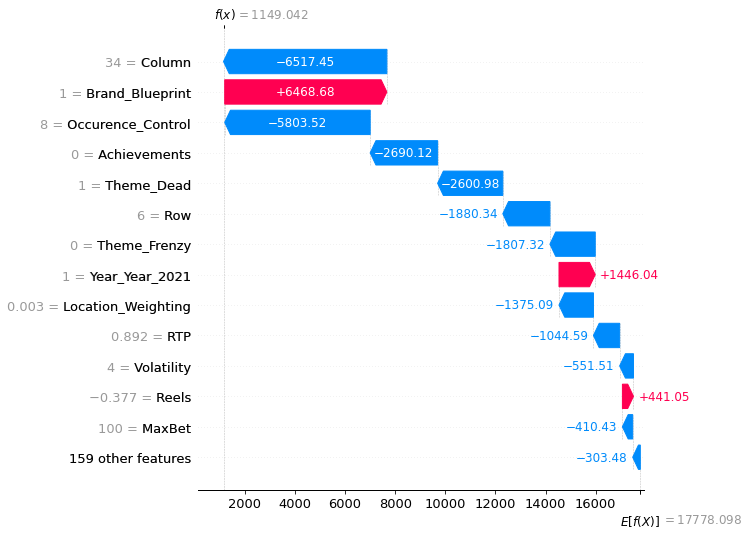

In [82]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[28], max_display=14)

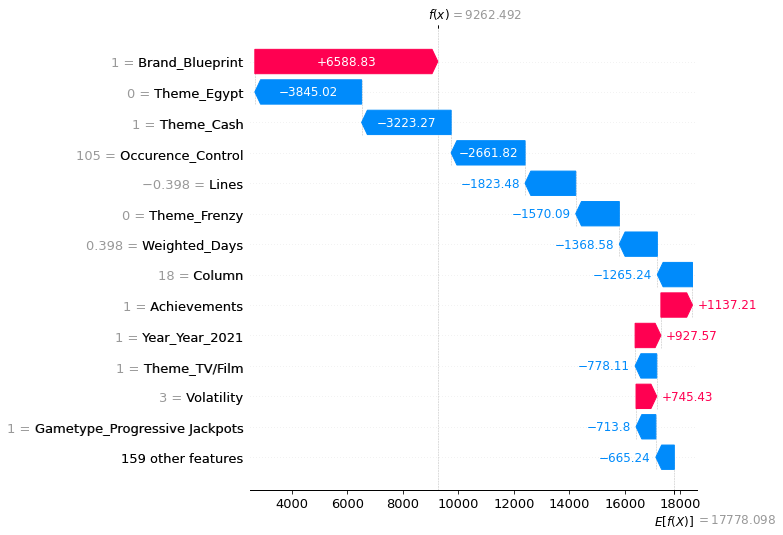

In [124]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[12], max_display=14)

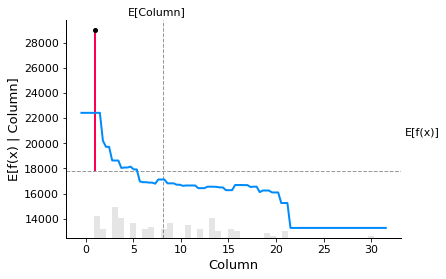

In [91]:
# make a standard partial dependence plot
sample_ind = 2238
shap.partial_dependence_plot(
    "Column", reg.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

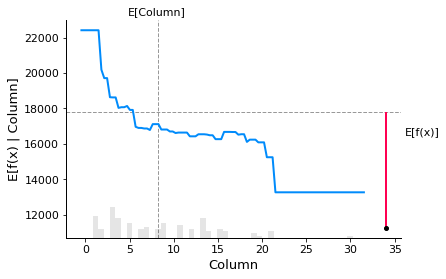

In [92]:
# make a standard partial dependence plot
sample_ind = 28
shap.partial_dependence_plot(
    "Column", reg.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

In [108]:
clustering = shap.utils.hclust(X_train, y_train)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
173it [06:56,  2.48s/it]                         


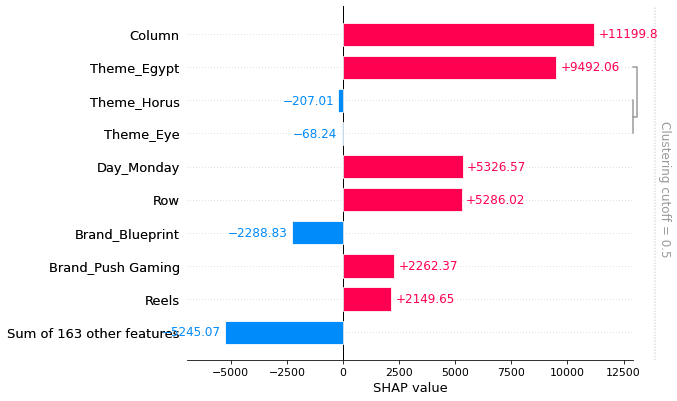

In [111]:
shap.plots.bar(shap_values[2238], clustering=clustering)